In [4]:
  # imports
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.python.layers.core import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import matthews_corrcoef


In [5]:
# import data
data = pd.read_csv("data.csv")

# EDA

In [6]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [7]:
data.dtypes

,0
Age,int64
Sex,object
ChestPainType,object
RestingBP,int64
Cholesterol,int64
FastingBS,int64
RestingECG,object
MaxHR,int64
ExerciseAngina,object
Oldpeak,float64


In [8]:
data.dtypes.isnull()

,0
Age,False
Sex,False
ChestPainType,False
RestingBP,False
Cholesterol,False
FastingBS,False
RestingECG,False
MaxHR,False
ExerciseAngina,False
Oldpeak,False


In [10]:
data.describe(include = "object")

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


In [9]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [11]:
data.duplicated(keep=False).value_counts()

,count
False,918


## Encoding

In [12]:
label_encoder = LabelEncoder()
categorical_encode = data.select_dtypes(include=['object']).columns.tolist()
for column in categorical_encode:
    data[column] = label_encoder.fit_transform(data[column].astype(str))
    print(f"Unique values in {column} Encoded: {np.sort(data[column].unique())}")

data_after_encoding = data.copy()
data.head()

Unique values in Sex Encoded: [0 1]
Unique values in ChestPainType Encoded: [0 1 2 3]
Unique values in RestingECG Encoded: [0 1 2]
Unique values in ExerciseAngina Encoded: [0 1]
Unique values in ST_Slope Encoded: [0 1 2]


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


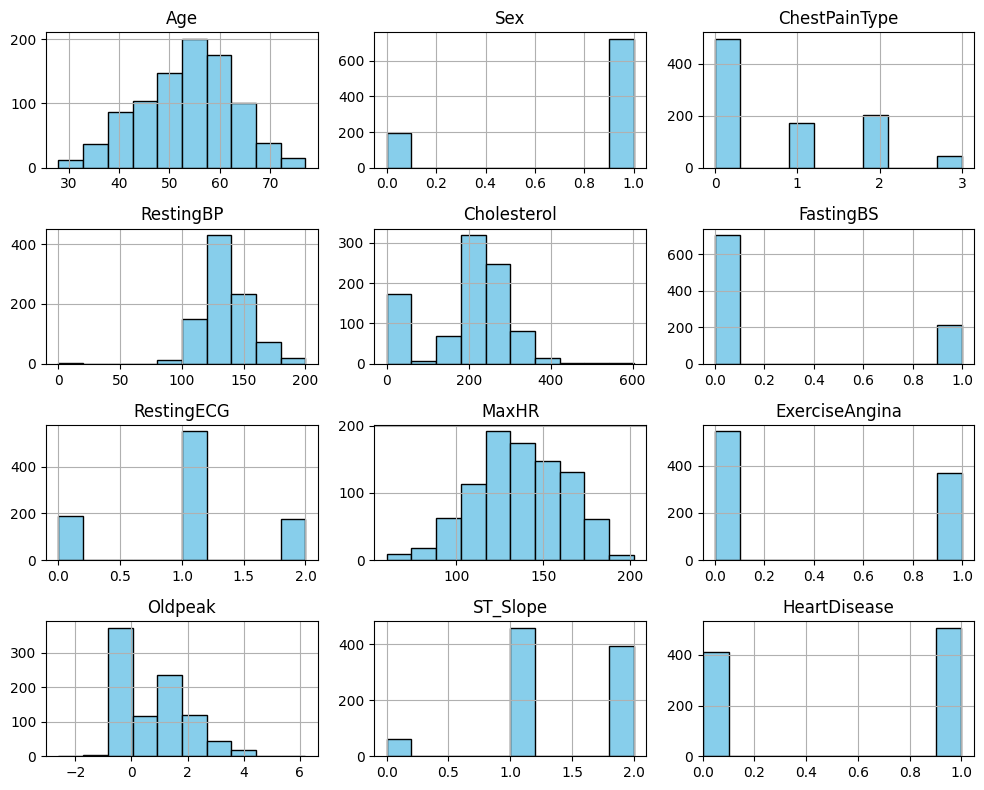

In [13]:
data.hist(figsize=(10, 8), bins=10, color='skyblue', edgecolor='black')
plt.xlim(left=0)
plt.tight_layout()
plt.show()

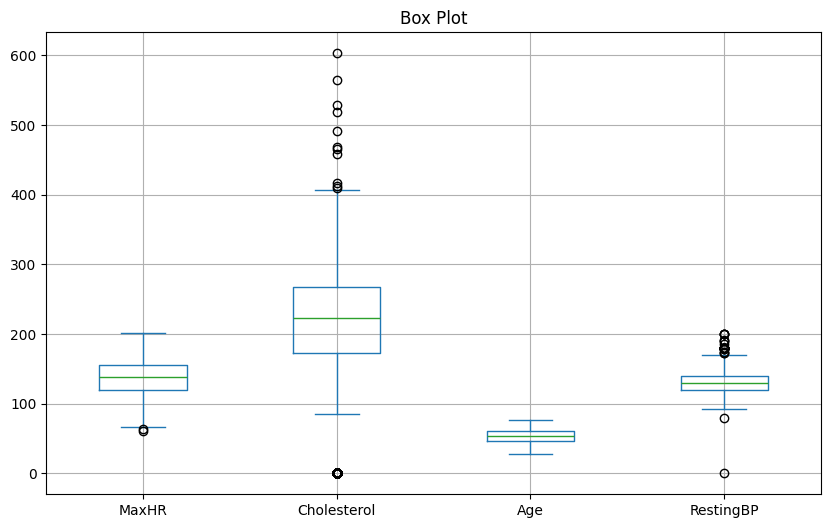

In [14]:
numerical_columns = ['MaxHR', 'Cholesterol', 'Age', 'RestingBP']
data[numerical_columns].plot(kind='box', figsize=(10, 6), grid=True)
plt.title("Box Plot")
plt.show()

In [15]:
# Converting age into bins representing different age groups
data['AgeGroups'] = pd.qcut(data['Age'], q=4, labels=[1, 2, 3, 4])
data.drop(['Age'], axis=1, inplace=True)

In [17]:
# Replacing cholesterol levels of zero with the median of this column
avg_cholesterol = data['Cholesterol'].replace(0, pd.NA).median()
data['Cholesterol'] = data['Cholesterol'].replace(0, avg_cholesterol)
# data = data[data['Cholesterol'] != 0]

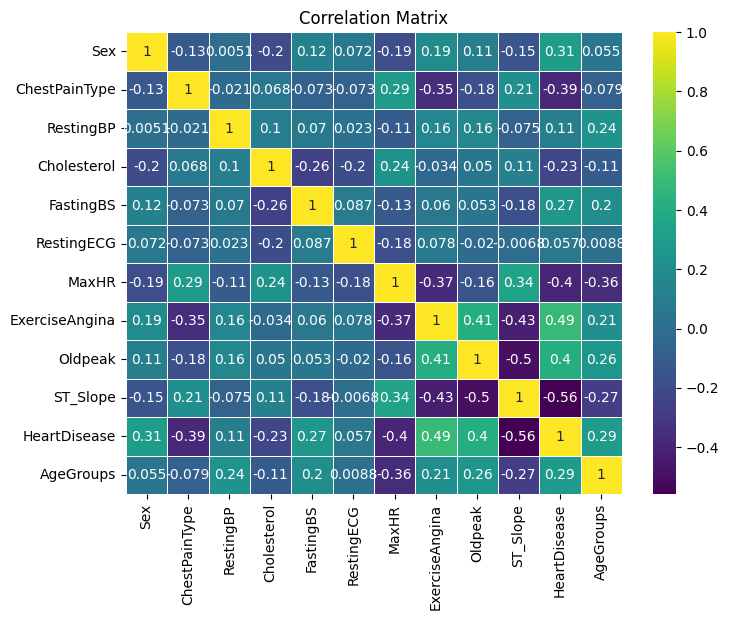

In [16]:
corr_matrix = data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Data Split

In [18]:
data_preprocessed = data.copy()
Y = data.pop('HeartDisease')
data_preprocessed.head()

,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,AgeGroups
0,1,1,140,289,0,1,172,0,0.0,2,0,1
1,0,2,160,180,0,1,156,0,1.0,1,1,2
2,1,1,130,283,0,2,98,0,0.0,2,0,1
3,0,0,138,214,0,1,108,1,1.5,1,1,2
4,1,2,150,195,0,1,122,0,0.0,2,0,2


In [19]:
# Scaling
def standardize(df, scaler, columns_to_scale=None, is_test=False):
    if columns_to_scale is None:
        columns_to_scale = ['RestingBP', 'Cholesterol', 'MaxHR']
    if is_test:
        df[columns_to_scale] = scaler.transform(df[columns_to_scale])
    else:
        df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    # print(df.shape)
    # print(df.head())
    return df, scaler

In [20]:
def split_data(data, Y, scaling=True):
    X_train_val, X_test, y_train_val, y_test = train_test_split(data, Y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
    if scaling:
        starter_scaler = StandardScaler()
        X_train_scaled, scaler = standardize(X_train, scaler=starter_scaler, is_test=False)
        X_val_scaled, _ = standardize(X_val, scaler=scaler, is_test=True)
        X_test_scaled, _ = standardize(X_test, scaler=scaler, is_test=True)
        return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test
    return X_train, X_val, X_test, y_train, y_val, y_test

# ML Model

Accuracy: 0.8478260869565217
              precision    recall  f1-score   support

           0       0.78      0.88      0.83        77
           1       0.91      0.82      0.86       107

    accuracy                           0.85       184
   macro avg       0.84      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



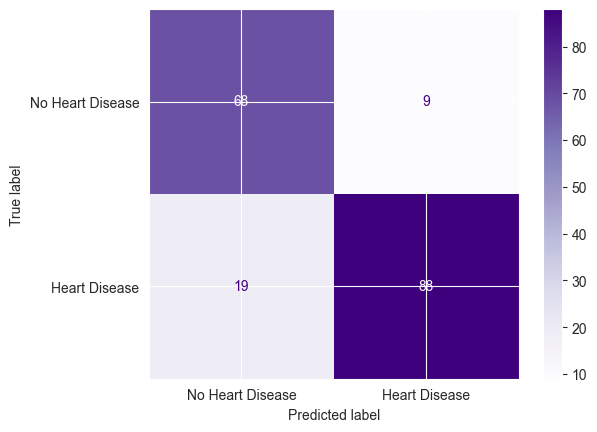

In [ ]:
# Split data
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data, Y)
# Definition & train
regression_model = LogisticRegression()
regression_model.fit(X_train, y_train)
y_pred_regression = regression_model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_regression))
print(classification_report(y_test, y_pred_regression))
cm_reg= confusion_matrix(y_test, y_pred_regression)
disp_reg = ConfusionMatrixDisplay(confusion_matrix=cm_reg, display_labels=["No Heart Disease", "Heart Disease"])
disp_reg.plot(cmap='Purples')

# Neural Network

In [21]:
# imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from keras import Input
from tensorflow.keras import backend as K

In [22]:
def plot_results(history):
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Plot the losses
    plt.figure(figsize=(8, 6))
    plt.plot(training_loss, label='Training Loss', color='blue', linewidth=2)
    plt.plot(validation_loss, label='Validation Loss', color='orange', linewidth=2)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

In [23]:
def plot_confusion_matrix(model, X_test, y_test, threshold=0.5):
    y_pred_probs = model.predict(X_test)
    prob_pred = (y_pred_probs > threshold).astype(int)
    cm = confusion_matrix(y_test, prob_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Heart Disease", "Heart Disease"])
    disp.plot(cmap="Blues", values_format='d')
    plt.title(f"Confusion Matrix")
    plt.xticks(rotation=45)
    plt.show()

In [24]:
def create_model(num_neurons, activation_func_name, learning_rate, X_train, X_val, X_test, y_train, y_val, y_test):
    K.clear_session()
    # Define model
    model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Use Input layer instead of input_shape in Dense
    Dense(num_neurons, activation=activation_func_name),
    Dense(1, activation='sigmoid')
    ])
    # Compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy'])
    # Train model
    history = model.fit(X_train, y_train,
                  validation_data=(X_val, y_val),
                  epochs=50, batch_size=32)
    # Evaluate
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    plot_results(history)
    plot_confusion_matrix(model, X_test, y_test)

### Basic Network

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5417 - loss: 0.8268 - val_accuracy: 0.6522 - val_loss: 0.6758
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6275 - loss: 0.7102 - val_accuracy: 0.6848 - val_loss: 0.5981
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6461 - loss: 0.6389 - val_accuracy: 0.7500 - val_loss: 0.5333
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6986 - loss: 0.5830 - val_accuracy: 0.7880 - val_loss: 0.4857
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7554 - loss: 0.5484 - val_accuracy: 0.8098 - val_loss: 0.4503
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7392 - loss: 0.5596 - val_accuracy: 0.8098 - val_loss: 0.4246
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7718 - loss: 0.5088 - val_accuracy: 0.8152 - val_loss: 0.4065
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7875 - loss: 0.4786 - val_accuracy: 0.8207 - val_loss

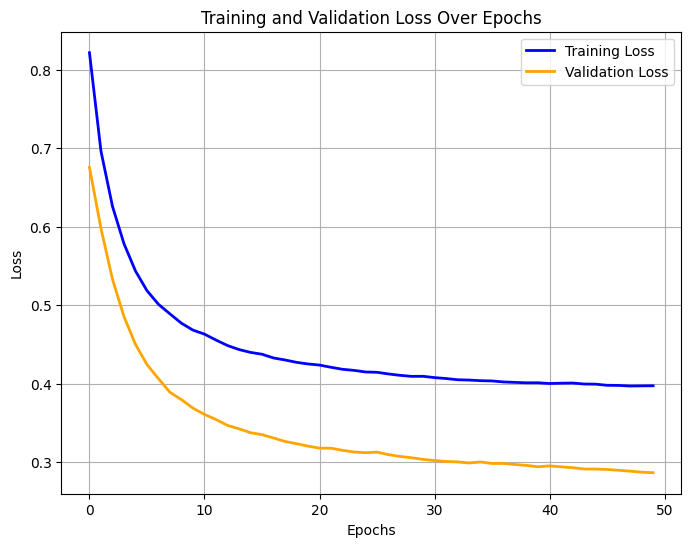

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


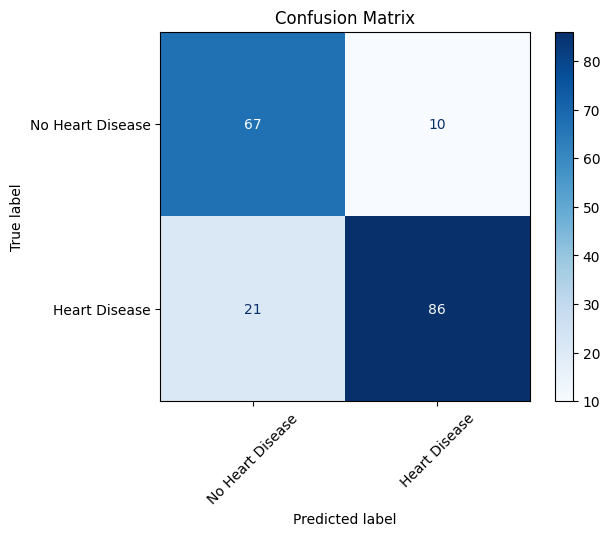

In [25]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data, Y)
create_model(16, None, 0.001, X_train, X_val, X_test, y_train, y_val, y_test)

# Experiments with Hyperparameter

## Hyperparameter - Learning Rate

In [ ]:
create_model(num_neurons=16, activation_func_name=None, learning_rate=0.01, X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test)
create_model(num_neurons=16, activation_func_name=None, learning_rate=0.1, X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test)
create_model(num_neurons=16, activation_func_name=None, learning_rate=0.01, X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test)

## Hyperparameter - Number of Neurons

In [ ]:
create_model(num_neurons=4, activation_func_name=None, learning_rate=0.01, X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test)
create_model(num_neurons=16, activation_func_name=None, learning_rate=0.01, X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test)
create_model(num_neurons=100, activation_func_name=None, learning_rate=0.01, X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test)

## Hyperparameter - Activation Function

In [ ]:
create_model(num_neurons=16, activation_func_name=None, learning_rate=0.01, X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test)
create_model(num_neurons=16, activation_func_name='relu', learning_rate=0.01, X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test)
create_model(num_neurons=16, activation_func_name='tanh', learning_rate=0.01, X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test)

# Data Modifications Scenarios

## Improved Data Scenario

In [ ]:
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)  # First quartile
        Q3 = df[col].quantile(0.75)  # Third quartile
        IQR = Q3 - Q1               # Interquartile range
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

In [ ]:
def balance_classes(df, column_name):
    min_count = df[column_name].value_counts().min()
    balanced_df = pd.concat([
        df[df[column_name] == val].sample(min_count, random_state=42)
        for val in df[column_name].unique()
    ])
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    print(balanced_df[column_name].value_counts())
    return balanced_df

HeartDisease
1    410
0    410
Name: count, dtype: int64
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3882 - loss: 0.8992 - val_accuracy: 0.4079 - val_loss: 0.8194
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4566 - loss: 0.7850 - val_accuracy: 0.5658 - val_loss: 0.6828
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5745 - loss: 0.6901 - val_accuracy: 0.6776 - val_loss: 0.6061
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6211 - loss: 0.6387 - val_accuracy: 0.7368 - val_loss: 0.5513
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6847 - loss: 0.5872 - val_accuracy: 0.7763 - val_loss: 0.5190
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7423 - loss: 0.5438 - val_accuracy: 0.7961 - val_loss: 0.4927
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7354 - loss: 0.5221 - val_accuracy: 0.8026 - val_loss: 0.4712
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy

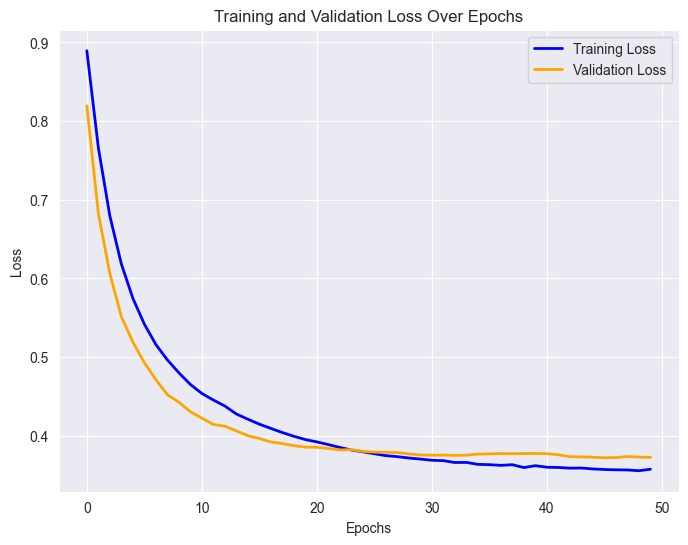

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


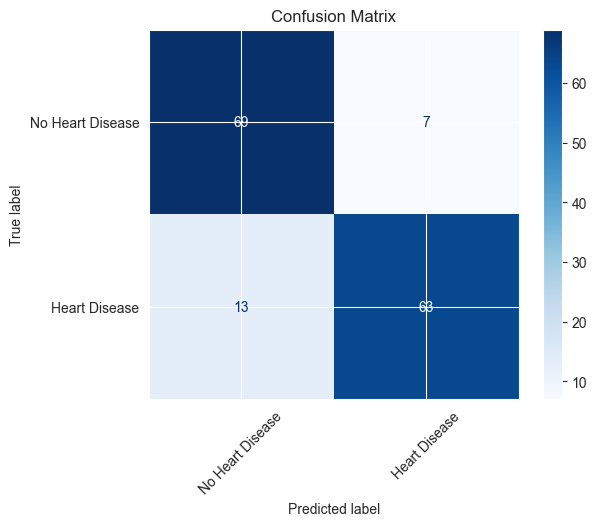

In [ ]:
# Reloading data
data_improved = data_preprocessed.copy()
# Additional pre-process
balanced_data_improved = balance_classes(data_improved, 'HeartDisease')
data_improved_without_outliers = remove_outliers(balanced_data_improved, ['Cholesterol', 'RestingBP', 'MaxHR'])
Y_improved = data_improved_without_outliers.pop("HeartDisease")
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data_improved_without_outliers, Y_improved)
create_model(16, None, 0.001, X_train, X_val, X_test, y_train, y_val, y_test)

## Bad Data Scenario

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5161 - loss: 0.8483 - val_accuracy: 0.5435 - val_loss: 0.7048
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5827 - loss: 0.6912 - val_accuracy: 0.6141 - val_loss: 0.6495
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5883 - loss: 0.6665 - val_accuracy: 0.6848 - val_loss: 0.6069
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6725 - loss: 0.6105 - val_accuracy: 0.7120 - val_loss: 0.5702
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7119 - loss: 0.5726 - val_accuracy: 0.7446 - val_loss: 0.5423
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6796 - loss: 0.5868 - val_accuracy: 0.7609 - val_loss: 0.5236
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7234 - loss: 0.5429 - val_accuracy: 0.7717 - val_loss: 0.5033
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7459 - loss: 0.5211 - val_accuracy: 0.7880 - val_loss

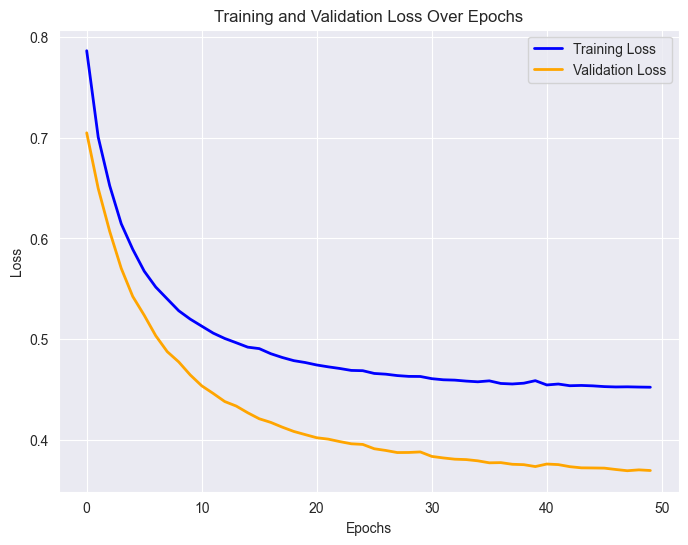

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


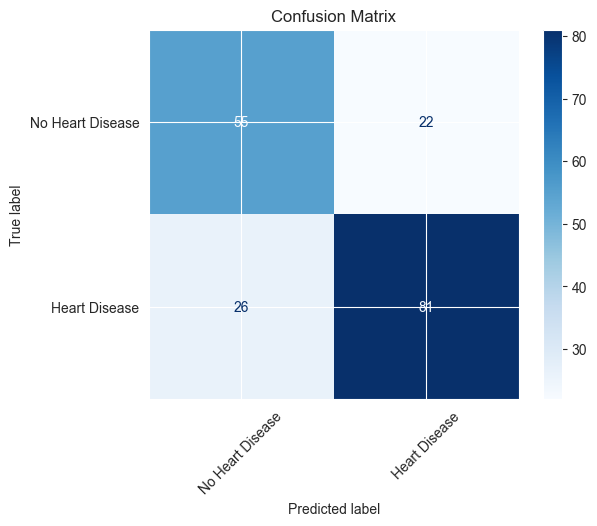

In [ ]:
data_bad = data_preprocessed.copy()
data_bad.drop(["ST_Slope", "ChestPainType"], axis=1, inplace=True)
Y_bad = data_bad.pop("HeartDisease")
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data_bad, Y_bad)
create_model(16, None, 0.001, X_train, X_val, X_test, y_train, y_val, y_test)

# Improving Model Architecture

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, BatchNormalization
def create_improved_model(num_neurons, activation_func_name, learning_rate, X_train, X_val, X_test, y_train, y_val, y_test):
    K.clear_session()
    # Define model
    model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Use Input layer instead of input_shape in Dense
    Dense(num_neurons, activation=activation_func_name),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
    ])
    # Compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate, weight_decay=0.01),
            loss='binary_crossentropy',
            metrics=['accuracy'])
    # Train model
    history = model.fit(X_train, y_train,
                  validation_data=(X_val, y_val),
                  epochs=40, batch_size=64)
    # Evaluate
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    plot_results(history)
    plot_confusion_matrix(model, X_test, y_test)

Epoch 1/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4909 - loss: 0.9053 - val_accuracy: 0.6793 - val_loss: 0.6031
Epoch 2/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7634 - loss: 0.5124 - val_accuracy: 0.7554 - val_loss: 0.4702
Epoch 3/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7662 - loss: 0.4379 - val_accuracy: 0.8370 - val_loss: 0.4004
Epoch 4/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8322 - loss: 0.3878 - val_accuracy: 0.8587 - val_loss: 0.3639
Epoch 5/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8013 - loss: 0.4265 - val_accuracy: 0.8696 - val_loss: 0.3481
Epoch 6/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8299 - loss: 0.3818 - val_accuracy: 0.8696 - val_loss: 0.3459
Epoch 7/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8256 - loss: 0.3818 - val_accuracy: 0.8804 - val_loss: 0.3361
Epoch 8/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8533 - loss: 0.3518 - val_accuracy: 0.8804 - val_loss: 0.3258
Epoch 9

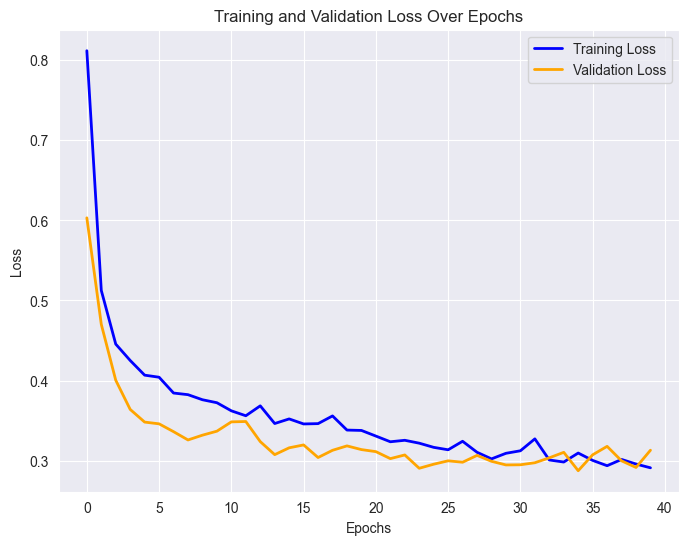

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


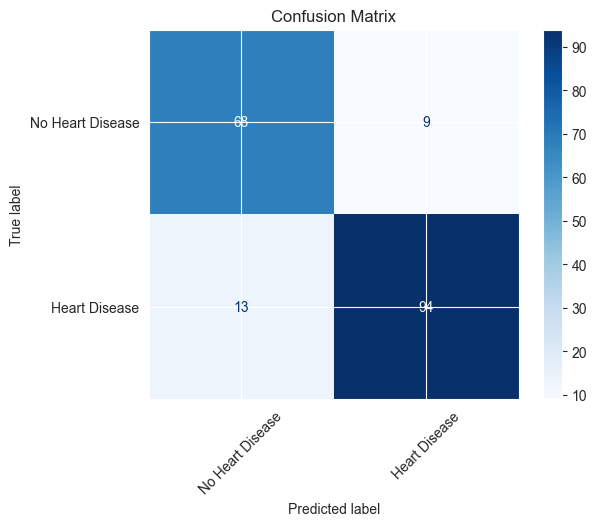

In [ ]:
data_new = data_preprocessed.copy()
Y_new = data_new.pop("HeartDisease")
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data_new, Y_new)
create_improved_model(16, 'relu', 0.01, X_train, X_val, X_test, y_train, y_val, y_test)

# New Metric

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt
import numpy as np

# Custom callback to track MCC
class MCCCallback(Callback):
    def __init__(self, X_val, y_val):
        self.X_val = X_val
        self.y_val = y_val
        self.mcc_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred_probs = self.model.predict(self.X_val)
        y_pred = (y_pred_probs > 0.5).astype(int)
        mcc = matthews_corrcoef(self.y_val, y_pred)
        self.mcc_scores.append(mcc)
        print(f"Epoch {epoch+1}: MCC = {mcc:.4f}")

def nn_newMatric(neurons, func, learning_rate, X_train, X_val, X_test, y_train, y_val, y_test):
    K.clear_session()
    model = Sequential([
        Dense(neurons, activation=func, input_shape=(X_train.shape[1],)),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Initialize MCC tracking
    mcc_callback = MCCCallback(X_val, y_val)

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=80, batch_size=32,
                        callbacks=[mcc_callback])  # Track MCC after each epoch

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Extract loss values from the history object
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

     # Plot MCC over epochs
    plt.figure(figsize=(8, 6))
    plt.plot(mcc_callback.mcc_scores, label='MCC Score', color='green', linewidth=2)
    plt.xlabel('Epochs')
    plt.ylabel('MCC')
    plt.title('MCC Score Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Predictions
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int)

    # Compute final MCC
    final_mcc = matthews_corrcoef(y_test, y_pred)
    print(f"Final MCC: {final_mcc:.4f}")


Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Epoch 1: MCC = -0.0034
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.4876 - loss: 0.9313 - val_accuracy: 0.4402 - val_loss: 0.8603
Epoch 2/80
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 2: MCC = 0.1685
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5406 - loss: 0.7970 - val_accuracy: 0.5380 - val_loss: 0.7334
Epoch 3/80
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 3: MCC = 0.3407
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6044 - loss: 0.6847 - val_accuracy: 0.6630 - val_loss: 0.6419
Epoch 4/80
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 4: MCC = 0.4762
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6818 - loss: 0.6245 - val_accuracy: 0.7446 - val_loss: 0.5805
Epoch 5/80
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 5: MCC = 0.5183
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6817 - loss: 0.6218 - val_accuracy: 0.7663 - val_loss: 0.5363
Epoch 6/80
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 6: MCC = 0.5741
18/

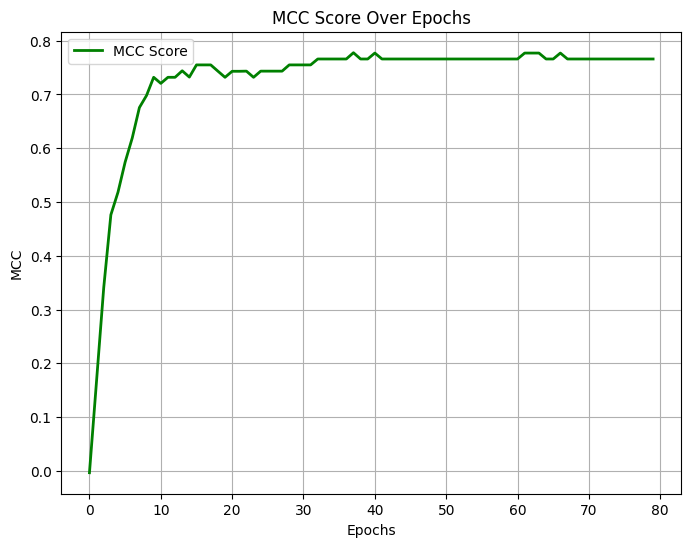

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Final MCC: 0.6971


In [31]:
data_new = data_preprocessed.copy()
Y_new = data_new.pop("HeartDisease")
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data_new, Y_new)
nn_newMatric(16, 'relu', 0.001, X_train, X_val, X_test, y_train, y_val, y_test)

# Unbalanced Data

In [36]:
import pandas as pd
from sklearn.utils import resample

cp_data = data_preprocessed.copy()
# Check the distribution of ChestPainType before balancing
print("Original Class Distribution:\n", cp_data["ChestPainType"].value_counts())

# Separate the dataset by ChestPainType category
df_0 = cp_data[cp_data["ChestPainType"] == 0]  # Most common class
df_1 = cp_data[cp_data["ChestPainType"] == 1]
df_2 = cp_data[cp_data["ChestPainType"] == 2]
df_3 = cp_data[cp_data["ChestPainType"] == 3]  # Least common class


max_size = df_0.shape[0]  # Majority class size
moderate_size = int(max_size * 0.7)  # Moderately balanced target size
full_size = max_size  # Fully balanced target size

df_1_moderate = resample(df_1, replace=True, n_samples=moderate_size, random_state=42)
df_2_moderate = resample(df_2, replace=True, n_samples=moderate_size, random_state=42)
df_3_moderate = resample(df_3, replace=True, n_samples=moderate_size, random_state=42)

# Combine the moderately balanced dataset
data_moderate = pd.concat([df_0, df_1_moderate, df_2_moderate, df_3_moderate])

df_1_full = resample(df_1, replace=True, n_samples=full_size, random_state=42)
df_2_full = resample(df_2, replace=True, n_samples=full_size, random_state=42)
df_3_full = resample(df_3, replace=True, n_samples=full_size, random_state=42)

# Combine the fully balanced dataset
data_full = pd.concat([df_0, df_1_full, df_2_full, df_3_full])

# Save the balanced datasets
cp_data.to_csv("unbalanced_cp_data.csv", index=False)
data_moderate.to_csv("moderate_balanced_cp_data.csv", index=False)
data_full.to_csv("full_balanced_cp_data.csv", index=False)

print("Moderate and Fully Balanced datasets created successfully!")

Original Class Distribution:
 ChestPainType
0    496
2    203
1    173
3     46
Name: count, dtype: int64
Moderate and Fully Balanced datasets created successfully!


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4820 - loss: 0.8299 - val_accuracy: 0.6685 - val_loss: 0.6265
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6416 - loss: 0.6296 - val_accuracy: 0.7391 - val_loss: 0.5420
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7034 - loss: 0.5797 - val_accuracy: 0.7663 - val_loss: 0.4963
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7353 - loss: 0.5482 - val_accuracy: 0.7935 - val_loss: 0.4630
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7558 - loss: 0.5242 - val_accuracy: 0.8207 - val_loss: 0.4392
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7727 - loss: 0.5068 - val_accuracy: 0.8261 - val_loss: 0.4177
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7613 - loss: 0.5058 - val_accuracy: 0.8478 - val_loss: 0.4011
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7735 - loss: 0.4957 - val_accuracy: 0.8533 - val_los

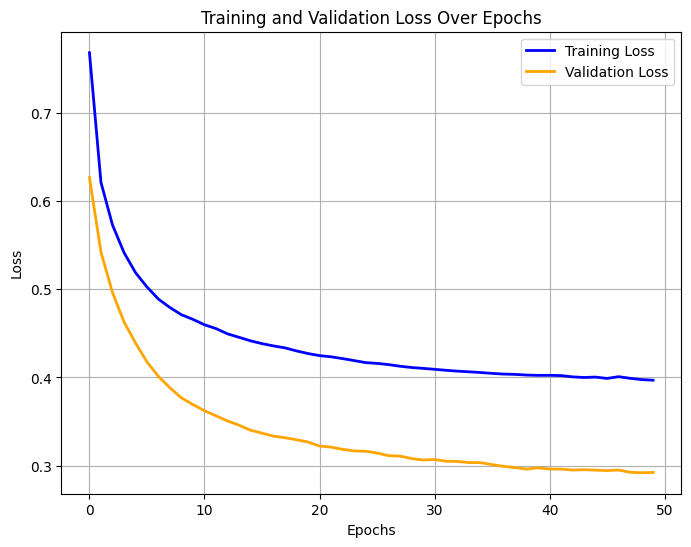

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


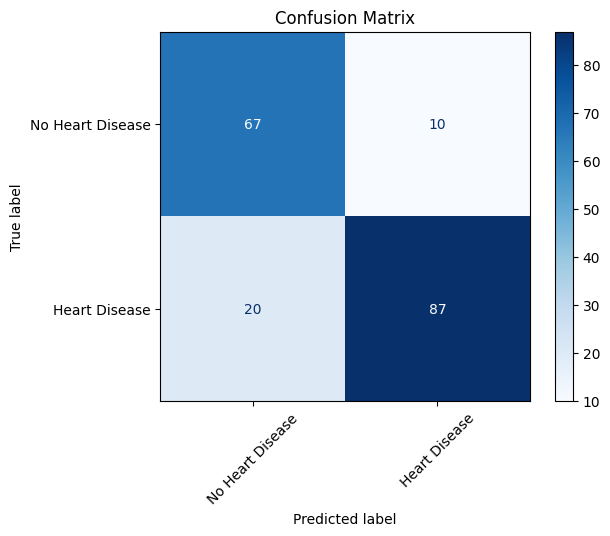

In [33]:
#Run the nural network on unbalanced data
data_new = data_preprocessed.copy()
Y_new = data_new.pop("HeartDisease")
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data_new, Y_new)
create_model(16, None, 0.001, X_train, X_val, X_test, y_train, y_val, y_test)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.3111 - loss: 1.0330 - val_accuracy: 0.3669 - val_loss: 0.8521
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4291 - loss: 0.8193 - val_accuracy: 0.5552 - val_loss: 0.7154
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5660 - loss: 0.7009 - val_accuracy: 0.6558 - val_loss: 0.6346
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6980 - loss: 0.5931 - val_accuracy: 0.6981 - val_loss: 0.5849
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7298 - loss: 0.5663 - val_accuracy: 0.7045 - val_loss: 0.5528
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7454 - loss: 0.5340 - val_accuracy: 0.7208 - val_loss: 0.5296
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7761 - loss: 0.4848 - val_accuracy: 0.7240 - val_loss: 0.5140
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7466 - loss: 0.4915 - val_accuracy: 0.7338 - val_los

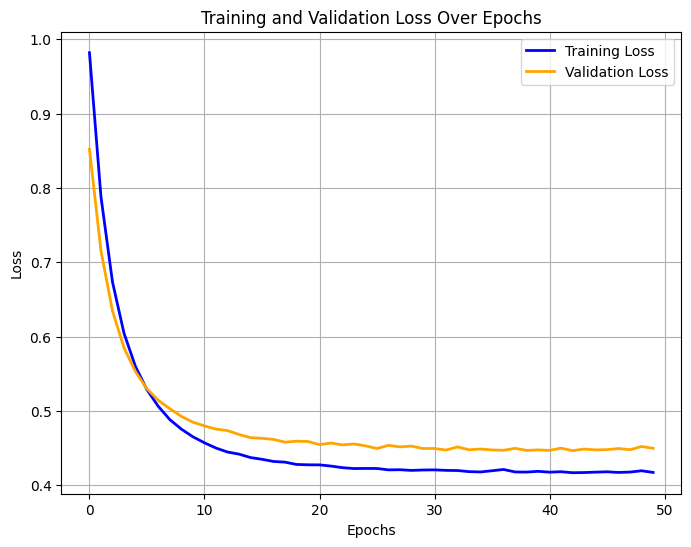

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


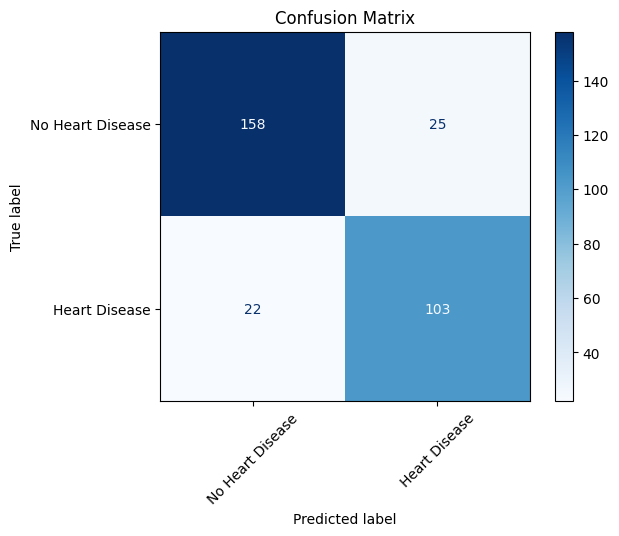

In [37]:
#Run the nural network on moderate balanced data
Y_new = data_moderate.pop("HeartDisease")
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data_moderate, Y_new)
create_model(16, None, 0.001, X_train, X_val, X_test, y_train, y_val, y_test)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4623 - loss: 0.8670 - val_accuracy: 0.5919 - val_loss: 0.6881
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6481 - loss: 0.6665 - val_accuracy: 0.7481 - val_loss: 0.5771
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7349 - loss: 0.5769 - val_accuracy: 0.7884 - val_loss: 0.5212
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7844 - loss: 0.5166 - val_accuracy: 0.8035 - val_loss: 0.4924
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8254 - loss: 0.4766 - val_accuracy: 0.8237 - val_loss: 0.4749
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8202 - loss: 0.4591 - val_accuracy: 0.8262 - val_loss: 0.4621
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8164 - loss: 0.4578 - val_accuracy: 0.8287 - val_loss: 0.4533
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8385 - loss: 0.4517 - val_accuracy: 0.8312 - val_loss

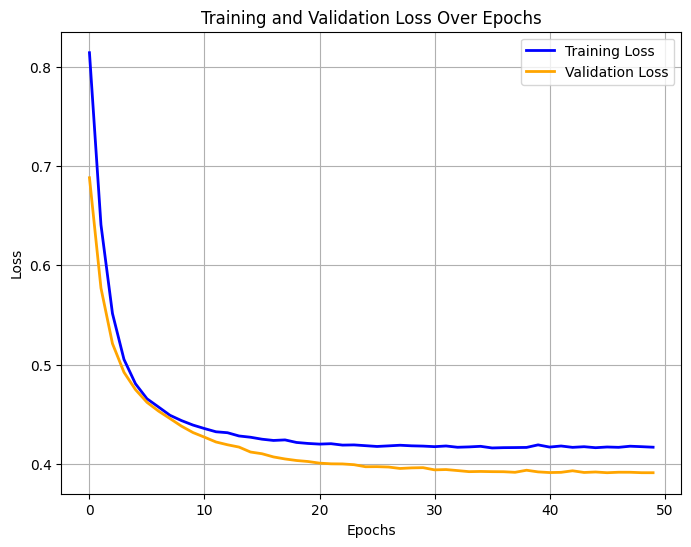

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


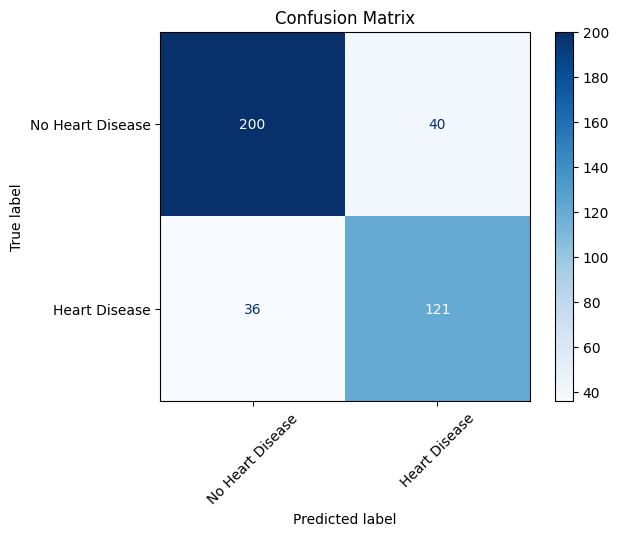

In [38]:
#Run the nural network on fully balanced data
Y_new = data_full.pop("HeartDisease")
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data_full, Y_new)
create_model(16, None, 0.001, X_train, X_val, X_test, y_train, y_val, y_test)

# PCA

In [ ]:
from sklearn.decomposition import PCA

data_for_pca = data_preprocessed.copy()
Y_pca = data_for_pca.pop("HeartDisease")
# Splitting data
X_train_val, X_test, y_train_val, y_test = train_test_split(data, Y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
# Scaling data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
# Performing PCA
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_scaled)  # Fit and transform training data
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)
print("Explained Variance Ratio: ", pca.explained_variance_ratio_)

Explained Variance Ratio:  [0.25488615 0.11681587 0.10178547 0.09111268 0.08623026]


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2441 - loss: 1.3131 - val_accuracy: 0.1848 - val_loss: 1.2575
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2296 - loss: 1.2023 - val_accuracy: 0.1848 - val_loss: 1.0884
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2466 - loss: 1.0476 - val_accuracy: 0.2120 - val_loss: 0.9462
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2808 - loss: 0.9076 - val_accuracy: 0.3043 - val_loss: 0.8265
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3320 - loss: 0.8209 - val_accuracy: 0.4239 - val_loss: 0.7219
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5012 - loss: 0.7067 - val_accuracy: 0.6196 - val_loss: 0.6412
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6618 - loss: 0.6489 - val_accuracy: 0.7989 - val_loss: 0.5749
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7887 - loss: 0.5809 - val_accuracy: 0.8750 - val_loss

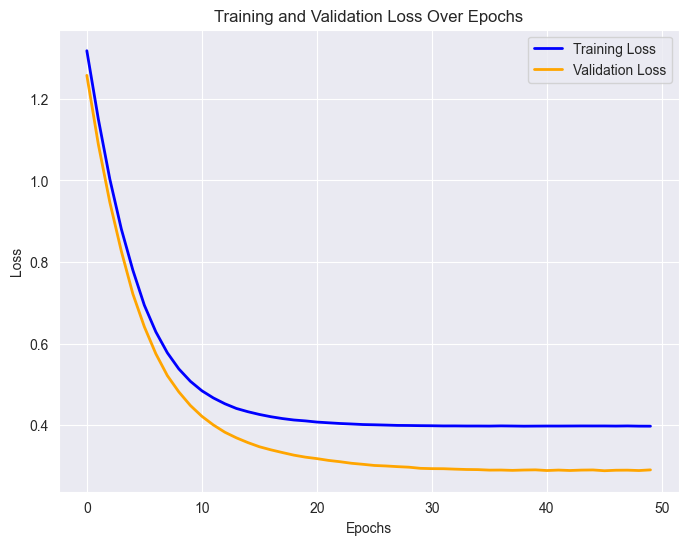

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


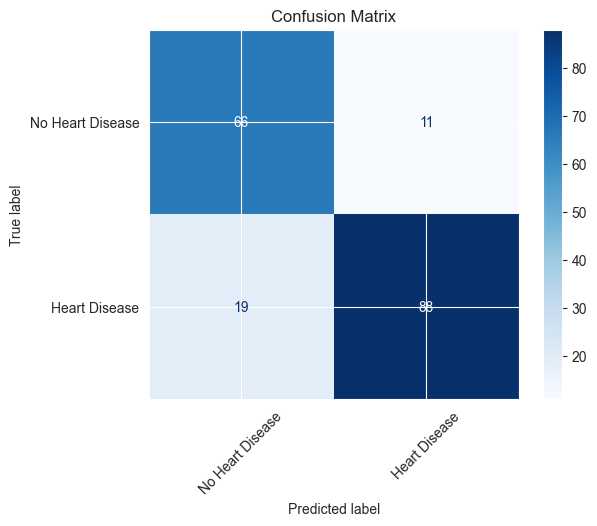

In [ ]:
create_model(16, None, 0.001, X_train_pca, X_val_pca, X_test_pca, y_train, y_val, y_test)

# The End